In [4]:
from pubg_util import mysql, load_schema, notifier
from sphynx import sphynx, NODE_SMALL, NODE_MEDIUM, NODE_LARGE
from pyspark.sql.functions import *
import pandas as pd
import pickle

spark = sphynx.get_spark(executor_count=4, app_name='west0', node_spec=NODE_LARGE)

Spark cluster not assigned. creating a new one...
Node spec: 4 executors with 48G RAM each
Job Port 4049 is assigned for requested cluster
Waiting for Spark master to be available...
Spark master launched!
Creating new Spark session, name: west0...
Waiting for all executors ready...
All executors connected!
Complete! elapsed time: 00:00:24


In [368]:
sphynx.stop()

Stopping Spark session...
Destroying Spark cluster...
Done!
You can safely ignore the warning message if there is any.


In [313]:
# user = load_data_mart("pc", "2022-01-18", "2022-01-18", "user_master").where(col("lastlogindate") >= "2022-01-12")

from pyspark.sql.types import * 
def classify_country(country_os, country_ip):
    if country_os != 'CN':
        return country_ip
    else:
        return country_os

country_type_udf = udf(classify_country, StringType())
meta_region = mysql.read_table(spark, 'metainfo', 'meta_bi_regions')

In [310]:
def get_user_info(device, start_date, end_date):
    membership = load_membership("pubg", device, start_date, end_date).select("date", "account_id", "membership").distinct()
    user = load_data_mart(device, end_date, end_date, "user_master").where(col("lastlogindate") >= start_date)
    user = user.withColumn("country_new", country_type_udf("country_os", "country_ip"))
    user = user.join(meta_region, user.country_new == meta_region.country_code_iso2, "left")
    user = user.withColumnRenamed("accountid", "account_id").select("account_id", "pubg_region")
    df = membership.join(user, "account_id", "left")
    return df

In [9]:
# end date, 2022-01-18 기준 membership
user = get_user_info("pc", "2022-01-12", "2022-01-18")

In [44]:
user.printSchema()

root
 |-- account_id: string (nullable = true)
 |-- date: date (nullable = true)
 |-- membership: string (nullable = true)
 |-- pubg_region: string (nullable = true)



In [11]:
user.groupBy("date").agg(count("*")).show()

+----------+--------+
|      date|count(1)|
+----------+--------+
|2022-01-15| 8352392|
|2022-01-18|10434919|
|2022-01-16| 9251055|
|2022-01-13| 5941943|
|2022-01-17| 9870021|
|2022-01-14| 7144126|
|2022-01-12| 4367006|
+----------+--------+



In [10]:
cash = load_data_mart("pc", "2022-01-12", "2022-01-18", "cash_mtx")
cash_df = cash.join(user, ["date", "account_id"], "left")

In [12]:
starter = cash_df.where(col("product_id") == "gcoinbundledesc.1016")

In [13]:
starter.groupBy("date", "membership").agg(countDistinct("account_id").alias("pu"), sum("ingame_revenue").alias("ingame_revenue")).toPandas().sort_values(["date", "membership"])

,date,membership,pu,ingame_revenue
11,2022-01-12,basic,18515,36720.29
20,2022-01-12,legacy,407327,809345.05
9,2022-01-12,plus,1691,3345.33
21,2022-01-13,basic,18382,36457.46
3,2022-01-13,legacy,154135,306151.29
1,2022-01-13,plus,1477,2924.67
12,2022-01-14,basic,16075,31899.01
18,2022-01-14,legacy,95955,190570.05
16,2022-01-14,plus,1331,2638.37
13,2022-01-14,None,2,3.98


In [14]:
starter.groupBy("membership").agg(countDistinct("account_id")).toPandas()

,membership,count(DISTINCT account_id)
0,None,2
1,plus,8768
2,basic,98333
3,legacy,861207


In [15]:
basic_user = starter.where(col("membership") == "basic").select("account_id").distinct().toPandas()["account_id"].tolist()
plus_user = starter.where(col("membership") == "plus").select("account_id").distinct().toPandas()["account_id"].tolist()

In [16]:
plused_user = []
still_basic = []
for i in basic_user:
    if i in plus_user:
        plused_user.append(i)
    else:
        still_basic.append(i)
print(len(plused_user))
print(len(still_basic))

0
98333


In [24]:
starter_buyer = starter.select("account_id", "membership", "pubg_region").distinct().toPandas()

In [199]:
# starter_buyer.to_csv("./data/starter_buyer.csv", index=False)
starter_buyer = pd.read_csv("./data/starter_buyer.csv")

In [19]:
# import pickle
# with open("./data/starter_buyer_list.txt", "wb") as f:
#     pickle.dump(starter_buyer_list, f)

In [47]:
legacy_user = starter_buyer[starter_buyer["membership"] == "legacy"]["account_id"].unique().tolist()

In [58]:
starter_buyer_user_list = starter_buyer["account_id"].unique().tolist()

In [59]:
# starter package 구매자들 중 legacy 가 아닌 유저들의 현금 구매 상품
starter_buyer_cash_buy = cash_df.where((~col("account_id").isin(legacy_user)) & (col("account_id").isin(starter_buyer_user_list))).toPandas()

In [200]:
# starter_buyer_cash_buy.to_csv("./data/starter_buyer_cash_buy.csv", index=False)
starter_buyer_cash_buy = pd.read_csv('./data/starter_buyer_cash_buy.csv')

In [102]:
starter_buyer_cash_buy.account_id.nunique()

107082

In [61]:
starter_buyer_cash_buy.groupby("account_id", as_index=False)["product_id"].count().describe()

,product_id
count,107082.000000
mean,1.492268
std,1.100467
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,40.000000


In [299]:
starter_buyer_cash_buy.groupby("account_id", as_index=False)["product_id"].count().groupby("product_id", as_index=False)["account_id"].count()

,product_id,account_id
0,1,77596
1,2,17197
2,3,7185
3,4,2762
4,5,1074
5,6,488
6,7,326
7,8,173
8,9,98
9,10,51


In [62]:
starter_buyer_cash_buy.groupby("product_name", as_index=False)["account_id"].count().sort_values("account_id", ascending=False)

,product_name,account_id
7,STARTER PACKAGE,107082
0,100 G-Coin,22759
6,BATTLEGROUNDS PLUS,11724
4,500(+10 Bonus) G-Coin,8181
1,1000(+50 Bonus) G-Coin,5981
3,2500(+200 Bonus) G-Coin,2944
5,5000(+500 Bonus) G-Coin,679
2,10000(+1200 Bonus) G-Coin,445


In [63]:
starter_buyer_cash_buy.groupby("product_name")["account_id"].nunique().reset_index().sort_values("account_id", ascending=False)

,product_name,account_id
7,STARTER PACKAGE,107082
0,100 G-Coin,14151
6,BATTLEGROUNDS PLUS,11723
4,500(+10 Bonus) G-Coin,6833
1,1000(+50 Bonus) G-Coin,4729
3,2500(+200 Bonus) G-Coin,2266
5,5000(+500 Bonus) G-Coin,510
2,10000(+1200 Bonus) G-Coin,273


In [64]:
# starterpack 구매자 중 멤버십이 두가지 이상 들어가는 경우가 있는지 확인
starter_buyer_cash_buy[starter_buyer_cash_buy["product_name"] == "STARTER PACKAGE"].groupby("account_id").filter(lambda x: len(x) > 1)

,date,account_id,platform,net_id,product_id,transaction_id,status,is_option,option_sales_ids,unit_sold,...,ingame_price,gcoin_topup,survivor_pass,levels_up,start_time,end_time,update_time,ingame_revenue,membership,pubg_region


In [66]:
# starter package 구매자들의 첫 cash상품 구매 시간
first_buy_time = starter_buyer_cash_buy.groupby("account_id", as_index=False)["time"].min()

In [71]:
first_buy_product = pd.merge(first_buy_time, starter_buyer_cash_buy, on=["account_id", "time"])

In [201]:
# first_buy_product.to_csv("./data/first_buy_product.csv", index=False)
first_buy_product = pd.read_csv("./data/first_buy_product.csv")

In [76]:
# starter package구매자들의 첫 현금 구매 상품
first_buy_product.groupby("product_name")["account_id"].count().reset_index().sort_values("account_id", ascending=False)

,product_name,account_id
7,STARTER PACKAGE,98057
6,BATTLEGROUNDS PLUS,5978
4,500(+10 Bonus) G-Coin,947
1,1000(+50 Bonus) G-Coin,912
0,100 G-Coin,594
3,2500(+200 Bonus) G-Coin,486
5,5000(+500 Bonus) G-Coin,83
2,10000(+1200 Bonus) G-Coin,26


In [99]:
# starter package 구매자들 중 plus 안산고 다른 상품 구매한 유저들
starter_and_plus_buyer_list = starter_buyer_cash_buy[starter_buyer_cash_buy["product_id"] == "gcoinbundledesc.1015"]["account_id"].unique().tolist()

In [101]:
len(starter_and_plus_buyer_list)

11723

In [106]:
# starter pakcage & plus 둘 다 구매한 유저들
starter_buyer_cash_buy[starter_buyer_cash_buy["account_id"].isin(starter_and_plus_buyer_list)].groupby("product_name", as_index=False)["account_id"].count()

,product_name,account_id
0,100 G-Coin,3831
1,1000(+50 Bonus) G-Coin,2035
2,10000(+1200 Bonus) G-Coin,378
3,2500(+200 Bonus) G-Coin,1466
4,500(+10 Bonus) G-Coin,2454
5,5000(+500 Bonus) G-Coin,431
6,BATTLEGROUNDS PLUS,11724
7,STARTER PACKAGE,11723


starter package 구매자 총 107,082  
starter package와 plus 둘다 구매한 유저: 11,723  
starter package는 구매하고 plus는 구매하지 않은 유저들의 소비가 plus 구매한 사용자들보다 낮음

plus는 구매 안하고 starter 산 유저들

In [103]:
starter_buyer_cash_buy[~starter_buyer_cash_buy["account_id"].isin(starter_and_plus_buyer_list)].groupby("product_name", as_index=False)["account_id"].count()

,product_name,account_id
0,100 G-Coin,18928
1,1000(+50 Bonus) G-Coin,3946
2,10000(+1200 Bonus) G-Coin,67
3,2500(+200 Bonus) G-Coin,1478
4,500(+10 Bonus) G-Coin,5727
5,5000(+500 Bonus) G-Coin,248
6,STARTER PACKAGE,95359


In [105]:
starter_buyer_cash_buy[~starter_buyer_cash_buy["account_id"].isin(starter_and_plus_buyer_list)].groupby("product_name")["account_id"].nunique().reset_index()

,product_name,account_id
0,100 G-Coin,11952
1,1000(+50 Bonus) G-Coin,3292
2,10000(+1200 Bonus) G-Coin,50
3,2500(+200 Bonus) G-Coin,1247
4,500(+10 Bonus) G-Coin,4951
5,5000(+500 Bonus) G-Coin,195
6,STARTER PACKAGE,95359


In [174]:
no_plus_cash_buy = starter_buyer_cash_buy[~starter_buyer_cash_buy["account_id"].isin(starter_and_plus_buyer_list)]
user_list = no_plus_cash_buy["account_id"].unique().tolist()

In [191]:
user_starter_buy_time = no_plus_cash_buy[no_plus_cash_buy.product_id == "gcoinbundledesc.1016"].groupby(["date", "account_id", "time"])["product_id"].count().reset_index()

In [193]:
user_starter_buy_time.to_csv("./data/user_starter_buy_time.csv", index=False)

In [223]:
len(user_list)

95359

In [224]:
# 2주간
starter_buyer_gcoin = load_data_mart("pc", "2022-01-12", "2022-01-25", "gcoin_use").where(col("account_id").isin(user_list))

In [227]:
# mysql.drop_table("labs", "starter_buyer_gcoin")

In [6]:
# mysql.insert_table(starter_buyer_gcoin.select("date", "platform", "account_id", "product_id", "product_name", "free_use", "paid_use", "price_", "time"), "labs", "starter_buyer_gcoin")
starter_buyer_gcoin = mysql.read_table(spark, "labs", "starter_buyer_gcoin")

In [179]:
# starter_buyer_gcoin_df = starter_buyer_gcoin.toPandas()

In [3]:
# starter_buyer_gcoin_df.to_csv("./data/starter_buyer_gcoin.csv", index=False)
starter_buyer_gcoin_df = pd.read_csv("./data/starter_buyer_gcoin.csv")

In [302]:
two_wk_use_user = starter_buyer_gcoin_df.account_id.unique().tolist()
print(len([i for i in user_list if i not in two_wk_use_user]))

18490


In [181]:
# 2주간 스타터팩 구매자들의 gcoin 사용량
starter_buyer_gcoin_df.groupby("account_id", as_index=False)[["free_use", "paid_use"]].sum().describe()

,free_use,paid_use
count,76869.000000,76869.000000
mean,857.858695,251.034617
std,402.630326,1313.959545
min,0.000000,0.000000
25%,510.000000,0.000000
50%,990.000000,0.000000
75%,1000.000000,90.000000
max,30780.000000,124590.000000


In [303]:
starter_buyer_gcoin_df.groupby("account_id", as_index=False)[["free_use", "paid_use"]].sum().sort_values("free_use", ascending=False)

,account_id,free_use,paid_use
28339,account.5ea7853c06fa489ca33890712c4ff223,30780,0
18790,account.3f09a85b69a04c1c84684af976b85292,16190,124590
67940,account.e2630929ce874b0db77e0633c43a4267,11410,97770
58994,account.c47315f25dd04b5c8fb82b1e33893fa2,9900,80000
40626,account.874354c7540246d6a4b0109115c8a343,8090,0
49929,account.a5e53cf010db4293bef8d3db554d31e0,7820,50000
8645,account.1d698e2387f44c869236dd4805429958,7490,3310
54110,account.b435c4be0a614c2e9709c5649645072c,7260,43600
26296,account.57fee6c0c9cd4ec3ab0fcfaa131659d5,6900,300
66813,account.dea051d84d3d43ef99ddef205ff31cbe,6530,55540


In [8]:
starter_buyer_gcoin.groupBy("product_name", "price_").agg(countDistinct("account_id").alias("pu"), sum(col("free_use")).alias("free_use"), sum(col("paid_use")).alias("paid_use")).orderBy("pu", ascending=False).toPandas()

,product_name,price_,pu,free_use,paid_use
0,EXTINCTION - CONTRABAND CRATE,200.00,31113,15155350,1622250
1,TRICK-OR-TREAT - CONTRABAND CRATE,200.00,13249,5824350,675450
2,YULE SLEIGH - CONTRABAND CRATE,200.00,6136,2145080,235520
3,COMIC COLORBURST - CONTRABAND CRATE,200.00,3857,1246800,205800
4,FEMALE FACE 17,500.00,3342,1530010,140990
5,FEMALE FACE 19,500.00,3298,1521610,127390
6,Polar Bear Feet,200.00,2724,489790,55010
7,GodV's M416,990.00,2619,2084590,508220
8,FEMALE FACE 18,500.00,2516,1160080,97920
9,SANTA SELFIE PACK,500.00,2425,1158840,53660


In [7]:
# free GCoin만 사용하여 구매한 상품
starter_buyer_gcoin.where(col("paid_use") == 0).groupBy("product_name", "price_").agg(countDistinct("account_id").alias("pu"), sum(col("free_use")).alias("free_use"), sum(col("paid_use")).alias("paid_use")).orderBy("pu", ascending=False).toPandas()

,product_name,price_,pu,free_use,paid_use
0,EXTINCTION - CONTRABAND CRATE,200.00,30122,14703000,0
1,TRICK-OR-TREAT - CONTRABAND CRATE,200.00,12566,5651200,0
2,YULE SLEIGH - CONTRABAND CRATE,200.00,5699,2081200,0
3,COMIC COLORBURST - CONTRABAND CRATE,200.00,3507,1197200,0
4,FEMALE FACE 17,500.00,2971,1485500,0
5,FEMALE FACE 19,500.00,2956,1478000,0
6,Polar Bear Feet,200.00,2369,473800,0
7,SANTA SELFIE PACK,500.00,2269,1134500,0
8,FEMALE FACE 18,500.00,2255,1127500,0
9,GodV's M416,990.00,1725,1707750,0


In [211]:
# paid GCoin 사용하여 구매한 상품
starter_buyer_gcoin.where(col("paid_use")>0).groupBy("product_name", "price_").agg(countDistinct("account_id").alias("pu"), sum(col("free_use")).alias("free_use"), sum(col("paid_use")).alias("paid_use")).orderBy("pu", ascending=False).toPandas()

,product_name,price_,pu,free_use,paid_use
0,EXTINCTION - CONTRABAND CRATE,200.00,5214,452350,1622250
1,TRICK-OR-TREAT - CONTRABAND CRATE,200.00,2083,173150,675450
2,EXTINCTION - CONTRABAND CRATE,1800.00,1137,590650,3158750
3,GodV's M416,990.00,894,376840,508220
4,Victory Dance 75,600.00,872,284910,238290
5,POLAR BEAR PACK,1290.00,871,543530,580060
6,YULE SLEIGH - CONTRABAND CRATE,200.00,852,63880,235520
7,COMIC COLORBURST - CONTRABAND CRATE,200.00,662,49600,205800
8,Victory Dance 62,600.00,590,167500,186500
9,FRESH HOODS CREW CROPPED PACK,700.00,579,200090,205210


In [182]:
starter_buyer_gcoin_df.groupby(["product_name", "product_id", "event_name", "price_"])["account_id"].nunique().reset_index().sort_values("account_id", ascending=False)

,product_name,product_id,event_name,price_,account_id
49,EXTINCTION - CONTRABAND CRATE,itemdesc.14100013,202201_wsus,200.00,31113
178,TRICK-OR-TREAT - CONTRABAND CRATE,itemdesc.14100010,202110_wsus_progressive,200.00,13249
215,YULE SLEIGH - CONTRABAND CRATE,itemdesc.14100012,202112_wsus_progressive,200.00,6136
29,COMIC COLORBURST - CONTRABAND CRATE,itemdesc.14100011,202111_wsus,200.00,3857
51,FEMALE FACE 17,itemdesc.13000325,202108_face,500.00,3342
53,FEMALE FACE 19,itemdesc.13000327,202108_face,500.00,3298
134,Polar Bear Feet,itemdesc.11030260,202112_xmas,200.00,2724
69,GodV's M416,itemdesc.12010502,202111_godv,990.00,2619
52,FEMALE FACE 18,itemdesc.13000326,202108_face,500.00,2516
148,SANTA SELFIE PACK,itemdesc.13000411,202112_xmas,500.00,2425


In [214]:
starter_buy_time = starter_buyer_cash_buy[starter_buyer_cash_buy.product_id == "gcoinbundledesc.1016"][["account_id", "time"]]

In [215]:
starter_buy_time.count()

account_id    107082
time          107082
dtype: int64

In [231]:
paid_gcoin_time = starter_buyer_gcoin.where(col("paid_use")>0).groupBy("account_id").agg(min("time").alias("buy_time")).toPandas()

In [247]:
# starter package 구매 시간과 처음 paid GCoin 사용 시간 차이
# time: starter pack 구매 시간
# buy_time: 처음 paid Gcoin 사용 시간
df = pd.merge(paid_gcoin_time, starter_buy_time, on="account_id")

In [270]:
df.shape

(20091, 4)

In [248]:
df[["buy_time", "time"]] = df[["buy_time", "time"]].apply(pd.to_datetime)

In [249]:
df.dtypes

account_id                 object
buy_time      datetime64[ns, UTC]
time          datetime64[ns, UTC]
dtype: object

In [250]:
df['time_diff'] = (df.buy_time - df.time).astype('timedelta64[h]')

In [289]:
starter_buyer_gcoin_df.time = starter_buyer_gcoin_df.time.apply(pd.to_datetime)

In [292]:
starter_buyer_gcoin_df.columns

Index(['date', 'platform', 'account_id', 'product_id', 'free_use',
       'free_balance', 'paid_use', 'paid_balance', 'price', 'qty', 'reason',
       'time', 'transaction_id', 'gcoin_by_expiry', 'type', 'is_salesid_exist',
       'sales_id_', 'device', 'currency', 'sales_id', 'exchange_id',
       'product_name', 'product_type', 'category', 'sub_category',
       'event_type', 'event_name', 'tags', 'part', 'tier', 'price_',
       'start_time', 'end_time', 'catalog_version', 'update_time'],
      dtype='object')

In [294]:
# starter package를 구매 후 처음으로 paid gcoin을 사용하여 구매한 상품
pd.merge(starter_buyer_gcoin_df, df[df["time_diff"] >= 0], left_on=["account_id", "time"], right_on=["account_id", "buy_time"]).groupby(["product_name", "price", "category"], as_index=False)["account_id"].count().sort_values("account_id", ascending=False)

,product_name,price,category,account_id
40,EXTINCTION - CONTRABAND CRATE,200,crates&keys,3459
157,TRICK-OR-TREAT - CONTRABAND CRATE,200,crates&keys,1238
107,POLAR BEAR PACK,1290,crates&keys,737
57,GodV's M416,990,skin,596
41,EXTINCTION - CONTRABAND CRATE,1800,crates&keys,575
181,Victory Dance 75,600,other,563
118,Polar Bear Mask,600,skin,475
47,FRESH HOODS CREW CROPPED PACK,700,crates&keys,453
190,YULE SLEIGH - CONTRABAND CRATE,200,crates&keys,420
131,SEASON'S GREETINGS SET,1090,crates&keys,356


In [295]:
pd.merge(starter_buyer_gcoin_df, df[df["time_diff"] >= 0], left_on=["account_id", "time"], right_on=["account_id", "buy_time"]).describe()

,free_use,free_balance,paid_use,paid_balance,price,qty,transaction_id,is_salesid_exist,sales_id_,sales_id,tier,price_,catalog_version,time_diff
count,18267.000000,18267.000000,18267.000000,18267.000000,18267.000000,18267.000000,1.826700e+04,18267.0,18267.000000,18267.000000,18267.000000,18267.000000,18267.0,18267.000000
mean,310.402912,138.890349,386.631083,153.727487,696.979800,1.000055,1.482662e+18,1.0,1707.548530,1707.548530,2.266656,696.979800,715.0,37.748508
std,332.131205,296.286684,408.675082,510.742579,513.416039,0.007399,1.143627e+15,0.0,250.578583,250.578583,2.082027,513.416039,0.0,64.984006
min,0.000000,0.000000,10.000000,0.000000,150.000000,1.000000,1.480614e+18,1.0,1.000000,1.000000,1.000000,150.000000,715.0,0.000000
25%,10.000000,0.000000,100.000000,0.000000,200.000000,1.000000,1.481819e+18,1.0,1622.000000,1622.000000,1.000000,200.000000,715.0,0.000000
50%,160.000000,20.000000,200.000000,0.000000,600.000000,1.000000,1.482414e+18,1.0,1815.000000,1815.000000,1.000000,600.000000,715.0,1.000000
75%,500.000000,200.000000,500.000000,90.000000,990.000000,1.000000,1.483214e+18,1.0,1878.000000,1878.000000,5.000000,990.000000,715.0,46.000000
max,1890.000000,10340.000000,4000.000000,9860.000000,4000.000000,2.000000,1.486097e+18,1.0,1890.000000,1890.000000,6.000000,4000.000000,715.0,318.000000


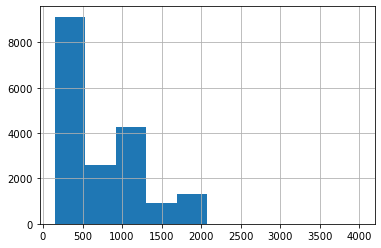

In [296]:
pd.merge(starter_buyer_gcoin_df, df[df["time_diff"] >= 0], left_on=["account_id", "time"], right_on=["account_id", "buy_time"]).price.hist()

In [251]:
df.describe()

,time_diff
count,20091.000000
mean,32.869046
std,64.311265
min,-148.000000
25%,0.000000
50%,0.000000
75%,38.000000
max,318.000000


In [274]:
df[df["time_diff"] >= 0].describe()

,time_diff
count,18267.000000
mean,37.748508
std,64.984006
min,0.000000
25%,0.000000
50%,1.000000
75%,46.000000
max,318.000000


In [285]:
df[df["time_diff"] >= 0].groupby("time_diff", as_index=False)["account_id"].count().sort_values("time_diff").head(30)

,time_diff,account_id
0,0.0,8306
1,1.0,867
2,2.0,457
3,3.0,279
4,4.0,212
5,5.0,168
6,6.0,129
7,7.0,101
8,8.0,77
9,9.0,55


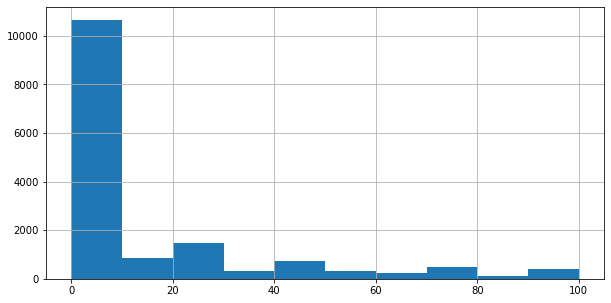

In [284]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
df[(df["time_diff"] >= 0) & (df["time_diff"] <= 100)].time_diff.hist()

In [254]:
# starter package 구매 전 다른 cash 상품 구매하여 GCoin 획득한 사용자
earlier = df[df["time_diff"] < 0]["account_id"].unique()

later = df[df["time_diff"] >= 0]["account_id"].unique()
print(len(earlier), len(later))

1824 18267


In [262]:
earlier_min_time = starter_buyer_cash_buy[starter_buyer_cash_buy.account_id.isin(earlier)].groupby("account_id", as_index=False)["time"].min()
earlier_min_buy = pd.merge(starter_buyer_cash_buy, earlier_min_time, on=["account_id", "time"])

In [265]:
earlier_min_buy.shape

(1824, 34)

In [268]:
earlier_min_buy.groupby(["product_name"])["account_id"].nunique().reset_index().sort_values("account_id", ascending=False)

,product_name,account_id
4,500(+10 Bonus) G-Coin,590
1,1000(+50 Bonus) G-Coin,523
0,100 G-Coin,320
3,2500(+200 Bonus) G-Coin,276
6,STARTER PACKAGE,64
5,5000(+500 Bonus) G-Coin,46
2,10000(+1200 Bonus) G-Coin,5


1.12 ~ 1.18 일주일간 스타터팩 구매자 & legacy가 아닌 유저중에서  
1760명이 starter package구매 전에 다른 cash 상품을 구매해 gcoin을 얼어 1.12~2주간 유료 gcoin 사용이력 있음

In [273]:
1760/20091*100
# 8.76%

8.76014135682644

In [183]:
top50_product = starter_buyer_gcoin_df.groupby(["product_name", "product_id", "event_name", "price_"])["account_id"].nunique().reset_index().sort_values("account_id", ascending=False).head(50)

In [184]:
top50_product

,product_name,product_id,event_name,price_,account_id
49,EXTINCTION - CONTRABAND CRATE,itemdesc.14100013,202201_wsus,200.00,31113
178,TRICK-OR-TREAT - CONTRABAND CRATE,itemdesc.14100010,202110_wsus_progressive,200.00,13249
215,YULE SLEIGH - CONTRABAND CRATE,itemdesc.14100012,202112_wsus_progressive,200.00,6136
29,COMIC COLORBURST - CONTRABAND CRATE,itemdesc.14100011,202111_wsus,200.00,3857
51,FEMALE FACE 17,itemdesc.13000325,202108_face,500.00,3342
53,FEMALE FACE 19,itemdesc.13000327,202108_face,500.00,3298
134,Polar Bear Feet,itemdesc.11030260,202112_xmas,200.00,2724
69,GodV's M416,itemdesc.12010502,202111_godv,990.00,2619
52,FEMALE FACE 18,itemdesc.13000326,202108_face,500.00,2516
148,SANTA SELFIE PACK,itemdesc.13000411,202112_xmas,500.00,2425


In [185]:
starter_buyer_gcoin_df[starter_buyer_gcoin_df["product_id"].isin(top50_product["product_id"].unique().tolist())]["account_id"].nunique()

67532

In [186]:
top50_buyer_list = starter_buyer_gcoin_df[starter_buyer_gcoin_df["product_id"].isin(top50_product["product_id"].unique().tolist())]["account_id"].unique().tolist()

In [187]:
starter_buyer_cash_buy[starter_buyer_cash_buy.account_id.isin(top50_buyer_list)].groupby("product_name")["account_id"].nunique().reset_index().sort_values("account_id", ascending=False)

,product_name,account_id
6,STARTER PACKAGE,67532
0,100 G-Coin,10797
4,500(+10 Bonus) G-Coin,4303
1,1000(+50 Bonus) G-Coin,2856
3,2500(+200 Bonus) G-Coin,1200
5,5000(+500 Bonus) G-Coin,193
2,10000(+1200 Bonus) G-Coin,49


In [163]:
product_gcoin = starter_buyer_gcoin_df.groupby(["account_id", "product_name"], as_index=False)["free_use", "paid_use"].sum()

In [164]:
product_gcoin.to_csv("./data/product_gcoin.csv", index=False)

 user_list들의 최근 구매 현황 (95359)

"2022-03-21" ~ "2022-04-03"

In [331]:
au = load_data_mart("pc", "2022-04-03", "2022-04-03", "user_master").where((col("lastlogindate") >= "2022-03-21") & (col("accountid").isin(user_list)))

In [338]:
membership = load_membership("pubg", "pc", "2022-04-03", "2022-04-03").where(col("account_id").isin(user_list)).select("date", "account_id", "membership").distinct()
user = au.withColumn("country_new", country_type_udf("country_os", "country_ip"))
user = user.join(meta_region, user.country_new == meta_region.country_code_iso2)
user = user.withColumnRenamed("accountid", "account_id").select("account_id", "pubg_region")
user = membership.join(user, "account_id")

In [339]:
user.select(countDistinct("account_id")).show()

+--------------------------+
|count(DISTINCT account_id)|
+--------------------------+
|                     27148|
+--------------------------+



In [340]:
print("Still Active", 27148/len(user_list)*100)

Still Active 28.469258276617833


In [341]:
user.groupBy("membership").agg(countDistinct("account_id")).toPandas()

,membership,count(DISTINCT account_id)
0,plus,5363
1,basic,21777
2,legacy,8


In [342]:
print("Plus %", 5363/len(user_list)*100)

Plus % 5.624010318900156


In [356]:
5363/27148

0.19754678060998968

In [363]:
cash = load_data_mart("pc", "2022-03-21", "2022-04-03", "cash_mtx").where(col("account_id").isin(user_list))

In [364]:
cash.select(countDistinct("account_id")).show()

+--------------------------+
|count(DISTINCT account_id)|
+--------------------------+
|                      3652|
+--------------------------+



In [353]:
cash.groupBy("product_name").agg(countDistinct("account_id").alias("pu"), count("*").alias("buy_cnt"), sum("ingame_revenue").alias("ingame_revenue")).toPandas()

,product_name,pu,buy_cnt,ingame_revenue
0,500(+10 Bonus) G-Coin,1094,1286,6419.06
1,1000(+50 Bonus) G-Coin,1186,1478,15028.96
2,100 G-Coin,840,1496,2000.99
3,BATTLEGROUNDS PLUS,456,456,5916.00
4,5000(+500 Bonus) G-Coin,288,336,16797.81
5,2500(+200 Bonus) G-Coin,559,658,16445.12
6,10000(+1200 Bonus) G-Coin,41,49,5099.69
7,HARDCORE HITMAN VALUE PACK,872,872,8631.64


In [365]:
gcoin = load_data_mart("pc", "2022-03-21", "2022-04-03", "gcoin_use").where(col("account_id").isin(user_list))

In [366]:
gcoin.select(countDistinct("account_id")).show()

+--------------------------+
|count(DISTINCT account_id)|
+--------------------------+
|                      5745|
+--------------------------+



In [367]:
gcoin.where(col("paid_use")>0).select(countDistinct("account_id")).show()

+--------------------------+
|count(DISTINCT account_id)|
+--------------------------+
|                      3788|
+--------------------------+



In [351]:
gcoin.groupBy("account_id").agg(sum("free_use").alias("free_use"), sum("paid_use").alias("paid_use"), count("*").alias("product_buy_cnt")).toPandas().describe()

,free_use,paid_use,product_buy_cnt
count,5745.000000,5745.000000,5745.000000
mean,564.363795,1230.715405,2.494865
std,604.800621,2472.666282,3.040812
min,0.000000,0.000000,1.000000
25%,120.000000,0.000000,1.000000
50%,390.000000,340.000000,2.000000
75%,950.000000,1240.000000,3.000000
max,10230.000000,44110.000000,58.000000


In [350]:
gcoin.groupBy("product_name", "price").agg(countDistinct("account_id").alias("pu"), count("*").alias("buy_cnt"), sum("free_use").alias("free_use"), sum("paid_use").alias("paid_use")).orderBy("buy_cnt", ascending=False).toPandas()

,product_name,price,pu,buy_cnt,free_use,paid_use
0,ZODIAC - CONTRABAND CRATE,200,907,2213,263760,178840
1,SURVIVOR PASS: PUNK WAVE WEAPON PACK,990,951,951,582520,358970
2,PunkWave Level UP,100,604,888,125600,269200
3,TIGER HUNTER - CONTRABAND CRATE,200,245,570,62210,51790
4,EXTINCTION - CONTRABAND CRATE,200,208,506,49830,51370
5,ZODIAC - CONTRABAND CRATE,1800,183,381,90180,595620
6,NIER:AUTOMATA - 2B COSTUME SET,2080,337,337,152810,548150
7,YULE SLEIGH - CONTRABAND CRATE,200,134,313,35940,26660
8,NIER MEGA BUNDLE,5450,249,249,128980,1228070
9,TIGER HUNTER - CONTRABAND CRATE,1800,76,171,32850,274950
